Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

## Colab

In [73]:
PATH = './drive/MyDrive/1_SP_Ham_func/'

# Mount your google drive 
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## Imports

In [ ]:
!pip install torchdiffeq

In [269]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time

In [270]:
# set device to GPU if available otherwise use CPU
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Available device : {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

device = set_device()

cpu


## Data Generation

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

### Plot functions for data

In [ ]:
def plot_traj_furuta(t_eval, q1, p1, q2, p2, energy=torch.tensor(False),
                     title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns
    if torch.any(energy):
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(15, 4),constrained_layout=True, sharex=True)# , sharey=True)
        ax5.plot(t_eval, energy, label='energy')

        # ax1.legend()
        ax5.set_title('Energy', fontsize=10)
        ax5.set_xlabel('time (s)')
        ax5.set_ylabel('E')
        ax5.set_ylim((0,torch.max(energy)*1.1))
    else:
       fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q1, label='q1')
    ax2.plot(t_eval, p1, label='p1')
    ax3.plot(t_eval, q2, label='q2')
    ax4.plot(t_eval, p2, label='p2')

    #ax1.legend()
    ax1.set_title('generalized position (q1)', fontsize=10)
    ax1.set_xlabel('time[s]')
    ax1.set_ylabel('q1[rad]')

    #ax2.legend()
    ax2.set_title('generalized momentum (p1)', fontsize=10)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('p1')

    ax3.set_title('generalized position (q2)', fontsize=10)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('q2[rad]')

    ax4.set_title('generalized momentum (p2)', fontsize=10)
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('p2')
    
    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q1}[rad/s]$')
        ax4.set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax4.set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return

### Dynamics

In [161]:
g = 9.81
Jr = 5.72*1e-5
Lr = 0.085
Mp = 0.024
Lp = 0.129
Jp = (1/12)*Mp*Lp**2

g = 9.81
Jr = 1*1e-2
Lr = 1
Mp = 1
Lp = 1
Jp = (1/12)*Mp*Lp**2

# function constants
C1 = Jr + Mp*Lr**2
C2 = (1/4)*Mp*Lp**2
C3 = (-1/2)*Mp*Lp*Lr
C4 = Jp+C2
C5 = (1/2)*Mp*g*Lp

print(C1,C2,C3,C4,C5)

1.01 0.25 -0.5 0.3333333333333333 4.905


In [217]:
g = 9.81
Jr = 1*1e-2
Lr = 0.25
Mp = 10
Lp = 0.25
Jp = (1/12)*Mp*Lp**2

# function constants
C1 = Jr + Mp*Lr**2
C2 = (1/4)*Mp*Lp**2
C3 = (-1/2)*Mp*Lp*Lr
C4 = Jp+C2
C5 = (1/2)*Mp*g*Lp

print(C1,C2,C3,C4,C5)

0.635 0.15625 -0.3125 0.20833333333333331 12.262500000000001


In [317]:
def furuta_H(q1,p1,q2,p2):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    ''' 

    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2

    
    # g = 9.81
    # Jr = 1*1e-2
    # Lr = 0.25
    # Mp = 10
    # Lp = 0.25
    # Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp



    # hamiltonian function
    H = p1**2 * (C1+C2*torch.sin(q1)**2 )+ C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)**2 - (C3**2) * (torch.cos(q1)**2)) 
    H = H + C5*(torch.cos(q1)+1)

    return H
    
def hamiltonian_fn_furuta(coords):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1,p1,q2,p2 = torch.split(coords,1)

    H = furuta_H(q1,p1,q2,p2)
    return H

def coord_derivatives_furuta(coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (default=0.0, float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (default=0.0, float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad=True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords)

    # gradient of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True) # !! might need to add H.sum() if batches used here later

    dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)

    dq1dt = dHdp1
    dp1dt = -dHdq1 -C_q1*dHdp1
    dq2dt = dHdp2
    dp2dt = -dHdq2 -C_q2*dHdp2

    return dq1dt, dp1dt, dq2dt, dp2dt
    
def dynamics_fn_furuta(t, coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u, C_q1,
                                                          C_q2)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S

### Trajectory

In [318]:
def random_uniform_two_interval():
    '''
      return x taken from a uniform distribution in one of two intervals 
      [-2,-0.3] or [0.3,2]
    Input : 
      None
    Outputs

    '''
    if torch.tensor([0.5]).bernoulli().bool():
        x = torch.zeros(1).uniform_(0.3,2)
    else:
        x = torch.zeros(1).uniform_(-2,-0.3)
    return x

In [319]:
def get_init_state():
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition
      
    '''
    y0 = torch.zeros(4)

    y0[0] = random_uniform_two_interval() 
    y0[2] = random_uniform_two_interval()

    y0[1]=0.0 # p1 = 0
    y0[3]=0.0 # p2 = 0
    return y0

In [320]:
def get_trajectory_furuta(timesteps=20, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    
    

    Ts = 0.005 # sampling time 
    t_eval = torch.linspace(1, timesteps, timesteps) * Ts # evaluated times vector
    t_span = [Ts, timesteps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state()

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, u, C_q1, C_q2), 
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts)) 

    q1, p1, q2, p2 = torch.chunk(q_p, 4, 1) 

    # add noise 
    q1 = (q1+torch.randn(q1.shape)*noise_std).detach().squeeze()
    p1 = (p1+torch.randn(p1.shape)*noise_std*torch.max(p1)).detach().squeeze()
    q2 = (q2+torch.randn(q2.shape)*noise_std).detach().squeeze()
    p2 = (p2+torch.randn(p2.shape)*noise_std*torch.max(p2)).detach().squeeze()
    
    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    return q1, p1, q2, p2, t_eval.detach()

In [266]:
# q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=10000, y0=None, noise_std=0.0, 
#                    u=0.0, C_q1=0.000009, C_q2=0.00004)

In [303]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=300, y0=None, noise_std=0.0, 
                   u=0.0) #, C_q1=0.000009, C_q2=0.00004)

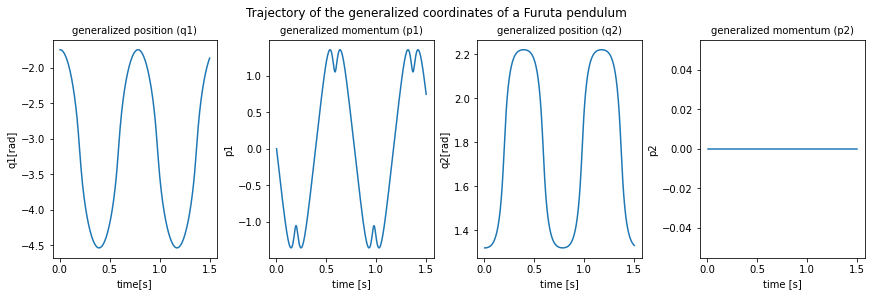

In [306]:
plot_traj_furuta(t_eval, q1, p1, q2, p2, title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

### Energy

In [321]:
def energy_furuta(dq1dt,dq2dt,q1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2
    
    # g = 9.81
    # Jr = 1*1e-2
    # Lr = 0.25
    # Mp = 10
    # Lp = 0.25
    # Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp
    
    E = (1/2)* dq2dt**2 * (C1+C2*torch.sin(q1)**2)+ dq2dt*dq1dt*C3*torch.cos(q1)
    E = E +(1/2)*dq1dt**2 *C4+C5*torch.cos(q1)+C5

    return E

def get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, p1, q2, p2),dim=1):

      dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u,
                                                            C_q1, C_q2)

      q1_n = coords[0]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n))
      derivatives.append(torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt)))
 
    energy = torch.hstack(energy).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

In [226]:
### NOT TESTED
def get_energy_furuta_newtonian(q1, dq1dt, q2, dq2dt, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, dq1dt, dq2dt),dim=1):

      q1_n = coords[0]
      dq1dt = coords[1]
      dq2dt = coords[2]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n))

    energy = torch.hstack(energy).detach()
    return energy

### Multiple trajectories

In [227]:
def multiple_trajectories_furuta(time_steps, num_trajectories, 
                          y0=torch.tensor([1.0,0.0,1.0,0.0]),
                          noise_std=0.0, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # the first trajectory
    q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=time_steps, 
                                                   y0=y0, noise_std=noise_std, 
                                                   u=u, C_q1=C_q1, C_q2=C_q2)
    
    energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=u, C_q1=C_q1, C_q2=C_q2)
    derivatives = derivatives.unsqueeze(dim=0)
    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q1_n, p1_n, q2_n, p2_n, t_eval_n = get_trajectory_furuta(
                     timesteps=time_steps, y0=y0, noise_std=noise_std, u=u, C_q1=0.0, C_q2=0.0)
        energy_n, derivatives_n = get_energy_furuta(q1_n, p1_n, q2_n, p2_n, u=u, C_q1=C_q1, C_q2=C_q2)

        q1 = torch.vstack((q1, q1_n))
        p1 = torch.vstack((p1, p1_n))
        q2 = torch.vstack((q2, q2_n))
        p2 = torch.vstack((p2, p2_n))

        
        energy = torch.vstack((energy, energy_n))
        derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))
        # t_eval = torch.vstack((t_eval, t_eval_n))
      
    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q1 = q1.unsqueeze(dim=0)
        p1 = p1.unsqueeze(dim=0)
        q2 = q2.unsqueeze(dim=0)
        p2 = p2.unsqueeze(dim=0)

        energy = energy.unsqueeze(dim=0)
        derivatives = derivatives

        #t_eval = t_eval.unsqueeze(dim=0)
    return q1, p1, q2, p2, energy, derivatives, t_eval

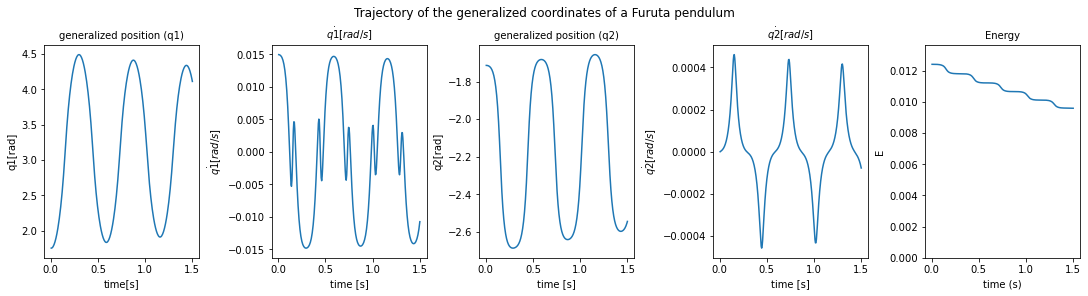

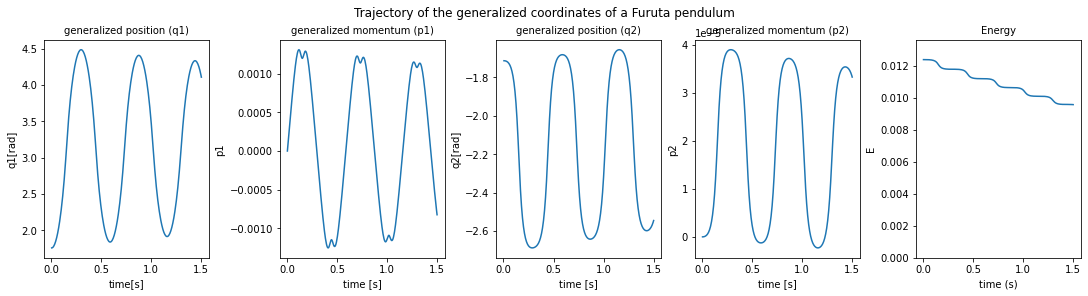

In [322]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=300, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.000009, C_q2=0.00004)
energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.000009, C_q2=0.00004)

plot_traj_furuta(t_eval, q1, derivatives[:,1], q2, derivatives[:,3], energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

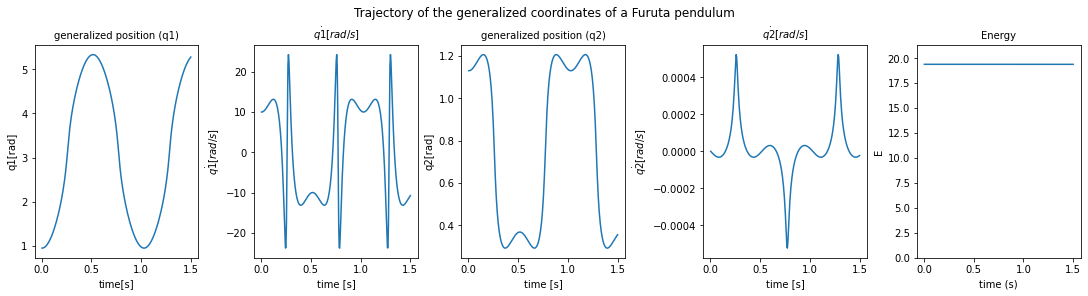

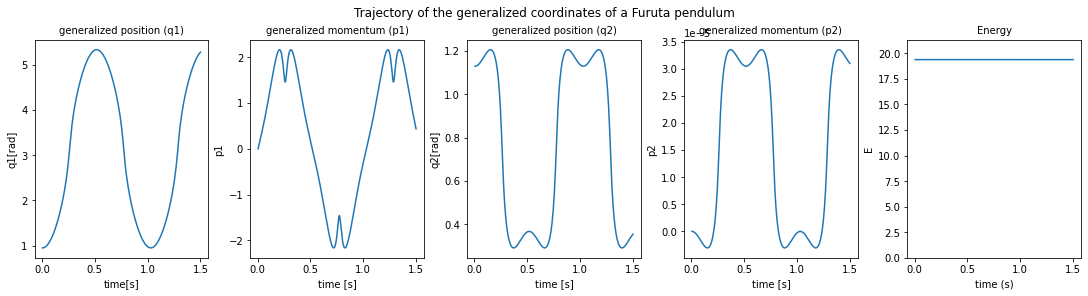

In [313]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=300, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.000009, C_q2=0.00004)
energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.000009, C_q2=0.00004)

plot_traj_furuta(t_eval, q1, derivatives[:,1], q2, derivatives[:,3], energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

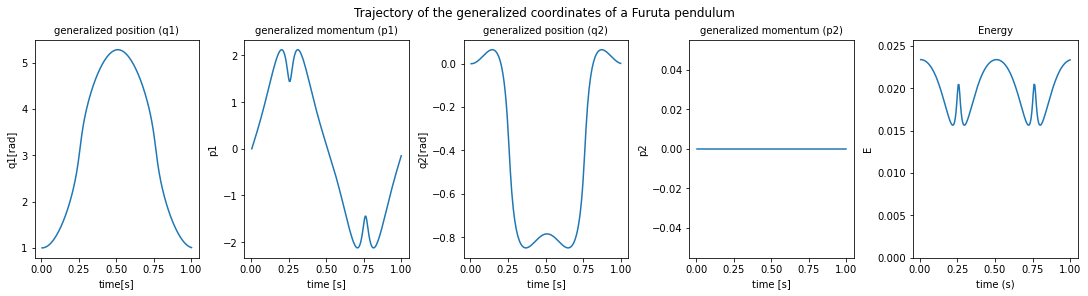

In [229]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=200, y0=torch.tensor([1.0,0.0,0.0,0.0]), noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)
energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.0, C_q2=0.0)

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

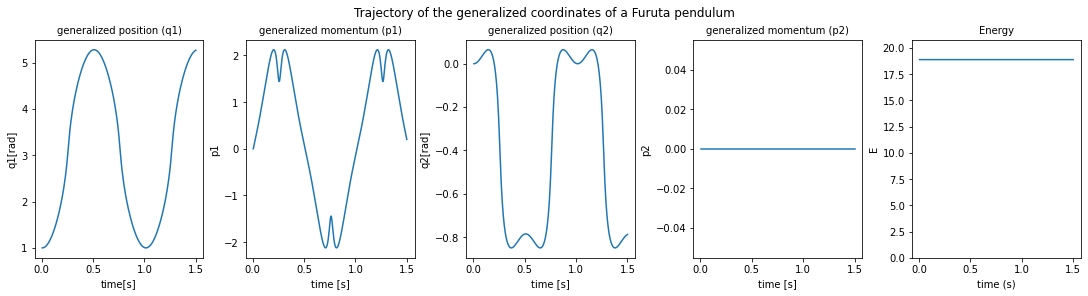

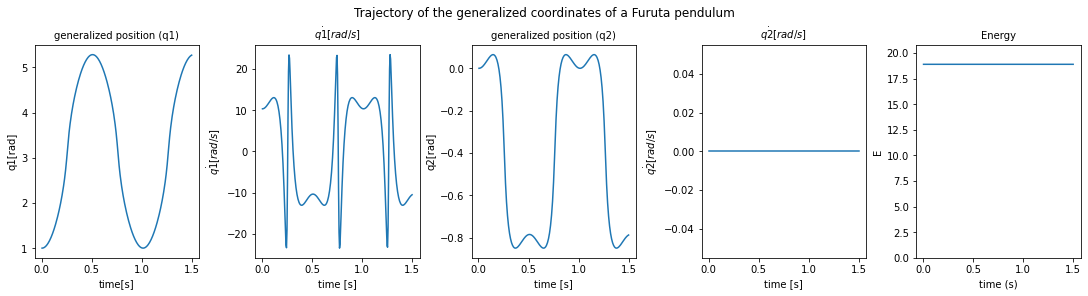

In [315]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, num_trajectories=3,
                                                                           y0=torch.tensor([1.0,0.0,0.0,0.0]),
                                                                           noise_std=0.0, 
                                                                           u=0.0,C_q1=0.0, C_q2=0.0)

plot_traj_furuta(t_eval, q1[0,:], p1[0,:], q2[0,:], p2[0,:], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

plot_traj_furuta(t_eval, q1[0,:], derivatives[0,:,1], q2[0,:], derivatives[0,:,3], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

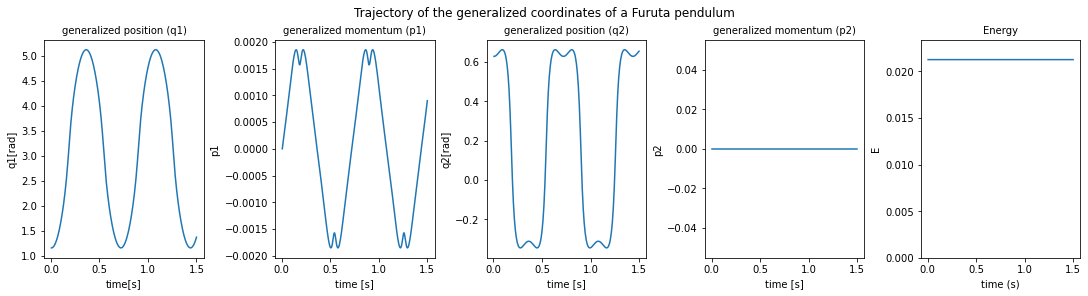

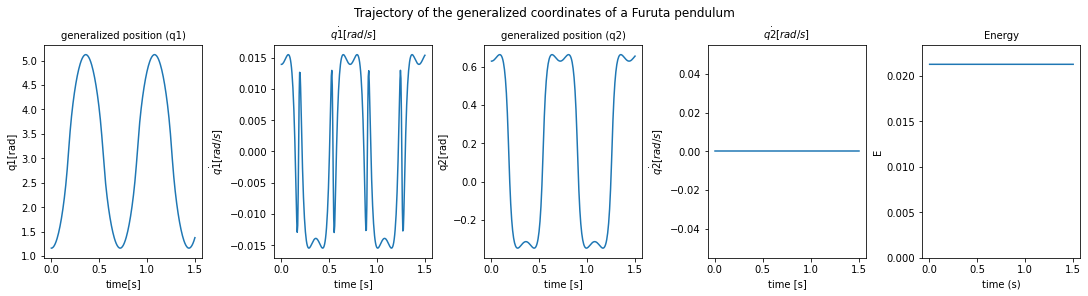

In [325]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, num_trajectories=3,
                                                                           y0=None,
                                                                           noise_std=0.0, 
                                                                           u=0.0,C_q1=0.0, C_q2=0.0)

plot_traj_furuta(t_eval, q1[0,:], p1[0,:], q2[0,:], p2[0,:], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

plot_traj_furuta(t_eval, q1[0,:], derivatives[0,:,1], q2[0,:], derivatives[0,:,3], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

In [ ]:
print(q1.shape) 
print(energy.shape)
print(derivatives.shape)
print(t_eval.shape)

torch.Size([3, 100])
torch.Size([3, 100])
torch.Size([3, 100, 4])
torch.Size([100])


### Dataset & Dataloader

In [ ]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    def __init__(self, q1, p1, q2, p2, t_eval, #energy=torch.tensor(False), 
                 derivatives, coord_type='hamiltonian' ):
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1 # [num_trajectories, time_steps]
        self.p1 = p1
        self.q2 = q2
        self.p2 = p2
        # if energy:
        #    self.energy = energy
        #if derivatives:
        self.dq1dt = derivatives[:,:,0] # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
        #self.dp1dt = derivatives[:,:,1]
        self.dq2dt = derivatives[:,:,2]
        #self.dp2dt = derivatives[:,:,4]
        
    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):
        
        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            
            x = torch.vstack((q1,p1,q2,p2))
            
        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]
            
            x = torch.vstack((q1,dq1dt,q2,dq2dt))
            
        t_eval = self.t_eval

        return x, t_eval

In [ ]:
def data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.5, coord_type='newtonian'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # split  into train and test 
    full_dataset = TrajectoryDataset_furuta(q1, p1, q2, p2, t_eval,derivatives, coord_type=coord_type)
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
            )    
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

In [326]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, 
                   num_trajectories=10, y0=None, noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)

train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=3,
                       shuffle = True, proportion = 0.5, coord_type='newtonian')

In [327]:
energy.shape

torch.Size([10, 300])

torch.Size([3, 4, 300])


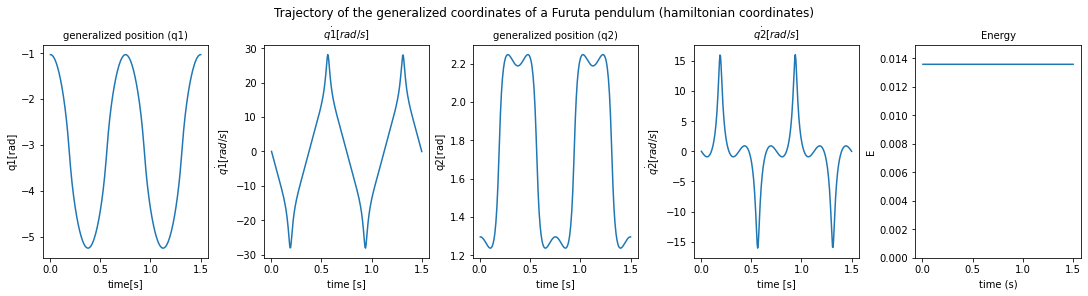

In [328]:
# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

q1_t = x_tt[0,0,:]
p1_t = x_tt[0,1,:]
q2_t = x_tt[0,2,:]
p2_t = x_tt[0,3,:]

plot_traj_furuta(t_eval_tt[0], q1_t, p1_t, q2_t, p2_t,energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='newtonian')

In [ ]:
train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=1,
                       shuffle = True, proportion = 0.5, coord_type='hamiltonian')

torch.Size([1, 4, 300])


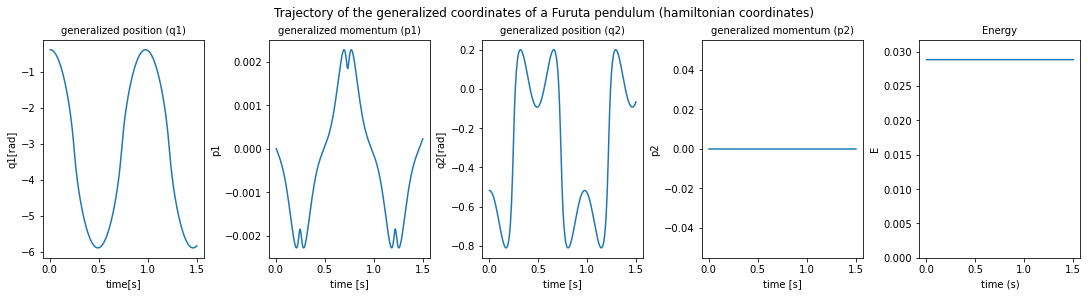

In [ ]:

# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

q1_t = x_tt[0,0,:]
p1_t = x_tt[0,1,:]
q2_t = x_tt[0,2,:]
p2_t = x_tt[0,3,:]

plot_traj_furuta(t_eval_tt[0], q1_t, p1_t, q2_t, p2_t,energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='hamiltonian')

torch.Size([1, 4, 300])


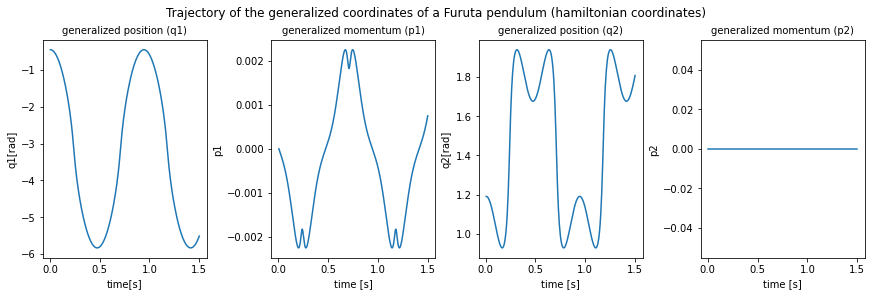

In [ ]:

# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

q1_t = x_tt[0,0,:].detach().cpu()
p1_t = x_tt[0,1,:].detach().cpu()
q2_t = x_tt[0,2,:].detach().cpu()
p2_t = x_tt[0,3,:].detach().cpu()
t_eval_tt = t_eval_tt.detach().cpu()
plot_traj_furuta(t_eval_tt[0,:], q1_t, p1_t, q2_t, p2_t,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='hamiltonian')

## Utils

In [ ]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:
      
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Plot functions for train & test

In [ ]:
def plot_furuta_hat_nom(data_loader_t,t_max,
                     title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                     , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    x_nom, t_eval = next(iter(data_loader_t))
    # predicted trajectory
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[:,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[:,0,1]
    q2_hat = x_hat[:,0,2]
    p2_hat = x_hat[:,0,3]

    E_hat, _ = get_energy_furuta(q1_hat, p1_hat, q2_hat, p2_hat, u=0, C_q1=0.0, C_q2=0.0)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat)
    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()
    
    # nominal trajectory
    q1_nom = x_nom[0,0,:]
    p1_nom = x_nom[0,1,:]
    q2_nom = x_nom[0,2,:]
    p2_nom = x_nom[0,3,:]

    E_nom, _ = get_energy_furuta(q1_nom, p1_nom, q2_nom, p2_nom, u=0, C_q1=0.0, C_q2=0.0)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom)

    t_eval = t_eval[0,:] # otherwise it is by batch


    fig, ax = plt.subplots(2, 3, figsize=(15, 4), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)
    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        ax[0,0].plot(t_eval[:t_max], q1[:t_max], label='train', c='g')
        ax[0,0].plot(t_eval[t_max:], q1[t_max:], label=label, c='r')

        ax[1,0].plot(t_eval[:t_max], p1[:t_max], label='train', c='g')
        ax[1,0].plot(t_eval[t_max:], p1[t_max:], label=label, c='r')

        ax[0,1].plot(t_eval[:t_max], q2[:t_max], label='train', c='g')
        ax[0,1].plot(t_eval[t_max:], q2[t_max:], label=label, c='r')

        ax[1,1].plot(t_eval[:t_max], p2[:t_max], label='train', c='g')
        ax[1,1].plot(t_eval[t_max:], p2[t_max:], label=label, c='r')

        ax[0,2].plot(t_eval[:t_max], E[:t_max], label='train', c='g')
        ax[0,2].plot(t_eval[t_max:], E[t_max:], label=label, c='r')

        ax[1,2].plot(t_eval[:t_max], H[:t_max], label='train', c='g')
        ax[1,2].plot(t_eval[t_max:], H[t_max:], label=label, c='r')



    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        ax[1,2].plot(t_eval, H, label=label)


    for j in range(3): # show all of the legends
      for i in range(2):
        ax[i,j].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')

    ax[0,2].set_title('Energy', fontsize=10)
    ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    ax[1,2].set_title('Hamiltonian', fontsize=10)
    ax[1,2].set_xlabel('time (s)')
    ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

In [ ]:
def plot_longer_horizon_furuta(test_loader,t1,t2, title = 'Trajectory after longer horizon', file_path=None):
    '''

    Description:

    Inputs:

    Outpus:
      
    '''
    x_nom, t_eval = next(iter(test_loader))

    # test trajectories
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[t1:t2,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[t1:t2,0,1]
    q2_hat = x_hat[t1:t2,0,2]
    p2_hat = x_hat[t1:t2,0,3]

    E_hat, _ = get_energy_furuta(q1_hat, p1_hat, q2_hat, p2_hat, u=0, C_q1=0.0, C_q2=0.0)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat)
    # H_hat = model.H_net(x_hat[t1:t2,0,:]).detach().squeeze()

    # nominal trajectories
    q1_nom = x_nom[0,0,t1:t2]
    p1_nom = x_nom[0,1,t1:t2]
    q2_nom = x_nom[0,2,t1:t2]
    p2_nom = x_nom[0,3,t1:t2]

    E_nom, _ = get_energy_furuta(q1_nom, p1_nom, q2_nom, p2_nom, u=0, C_q1=0.0, C_q2=0.0)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom)

    t_eval = t_eval[0,t1:t2]

    fig, ax = plt.subplots(2, 2, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction'],[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)

        ax[1,0].plot(t_eval, E, label=label)
        ax[1,0].set_title('Energy', fontsize=10)
        ax[1,0].set_xlabel('time (s)')
        ax[1,0].set_ylabel('E')
          
        ax[1,1].plot(t_eval, H, label=label)
        ax[1,1].set_title('Hamiltonian', fontsize=10)
        ax[1,1].set_xlabel('time (s)')
        ax[1,1].set_ylabel('H')

    #ax[1,0].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    for j in range(2): # show all of the legends
      for i in range(2):
        ax[i,j].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')
    fig.suptitle(title, fontsize=12)
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return 

In [ ]:
def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None,
                            horizons = [100,150,200,250,300],
                            horizon_steps = [200,400,550,700,850],
                            title='train and test loss per epoch'):
    ''' 
    Description:

    Inputs:

    Outpus:
      
    '''
    fig, ax = plt.subplots(figsize=(10,4))#,constrained_layout=True)
    #fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')

    if not loss_test == []: # if loss_test exists
        plt.plot(epochs[::10], loss_test, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

    if horizons:
        for i, epoch_num in enumerate(horizon_steps[:-1]):
            ax.annotate(
            'horizon = %d'%horizons[i],
            xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
            xytext=(-70, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc,angleA=0,armA=50,rad=10"
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"
                            ))
        ax.annotate(
        'horizon = %d'%horizons[-1],
        xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
        xytext=(+20, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

## Models

### Base models

In [ ]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

In [ ]:
class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x

In [301]:
class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x, separate_fields=False):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

### MLP_U_HNN

In [ ]:
class Simple_MLP(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, input_dim, H_net=None, device=None):
        super(Simple_MLP, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 # - self.C1_dissip*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 # - self.C2_dissip*dHdp2

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 

            return S_h

In [ ]:
H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
count_parameters(H_net)

33301

### Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module):
    '''
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=2, dec_in_dim = 2, dec_out_dim = 2, activation='tanh'):
        super(Autoencoder, self).__init__()

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)
        q, p=torch.split(x,2,dim=-1)

        p_hat = self.encoder(x) # coordinates in the latent space

        z_h = torch.cat((q,p_hat),dim=2) # input known q and encoded z into decoder

        q_dot_hat = self.decoder(z_h) # coordinates back in the original space but using the decoder
        return p_hat, q_dot_hat

In [ ]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=4, 
                 enc_out_dim=2, dec_in_dim = 4, dec_out_dim = 2, activation='tanh')

In [ ]:
count_parameters(autoencoder)

9220

In [ ]:
x.shape

NameError: name 'x' is not defined

In [ ]:
x = torch.permute(x,(0,2,1))

In [ ]:
x.shape

torch.Size([2, 300, 4])

In [ ]:
output1, output2 = autoencoder(x)
print(output1.shape)
print(output2.shape)

torch.Size([2, 300, 2])
torch.Size([2, 300, 2])


### Train functions

In [ ]:
def L2_loss(u, v, w = False, dim = (0,1)):
    # u and v expected with shape : [time_steps,batch_size , (q1,p1,q2,p1)] 
    if torch.is_tensor(w):
        # mean only over time steps and batch_size
        loss = (((u-v)).pow(2).mul(w)).mean(dim = dim ).sum()
    else :
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    return loss

In [ ]:
u = torch.ones(5,5,4)
v = torch.zeros(5,5,4)
w = torch.tensor([0.0,1.0,2.0,1.0])

In [ ]:
(((u-v)).pow(2).mul(w)).mean()

tensor(1.)

In [ ]:
(((u-v)).pow(2).mul(w)).shape

torch.Size([5, 5, 4])

In [ ]:
(((u-v)).pow(2).mul(w)).mean(dim = (0,1) ).sum()

tensor(4.)

In [ ]:
def load_model():
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model 

In [ ]:
def load_data_device(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                      num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                      u=0.0,C_q1=0.0, C_q2=0.0)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)

    stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])
    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader, stds

In [ ]:
train_loader, test_loader, stds = load_data_device(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1)

In [ ]:
1/(stds+1e-10)

tensor([4.4984e-01, 8.1344e+02, 7.1702e-01, 1.0000e+10])

In [ ]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, 
                      num_trajectories=100, y0=None, noise_std=0.0, 
                      u=0.0,C_q1=0.0, C_q2=0.0)

In [ ]:
q1.shape

torch.Size([100, 300])

In [ ]:
t_eval.shape

torch.Size([300])

In [ ]:
n = 60

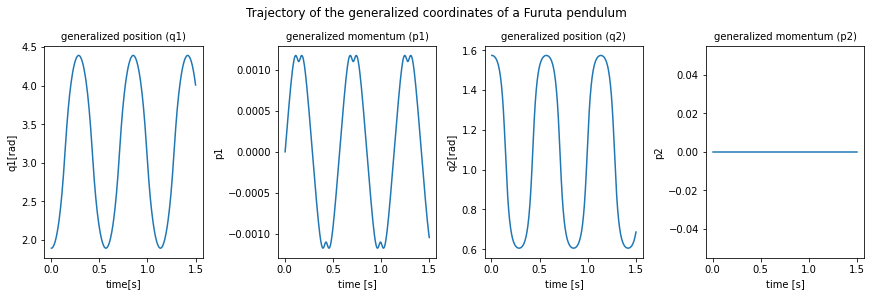

In [ ]:
plot_traj_furuta(t_eval, q1[n,:], p1[n,:], q2[n,:], p2[n,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

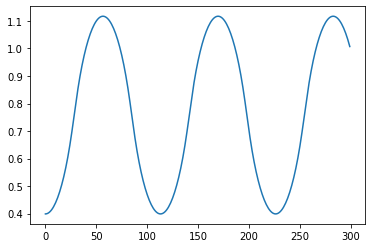

In [ ]:
plt.plot((q1[n,:]-q1.mean()) /q1.std())

In [ ]:
1/q1.std()

tensor(0.2873)

In [ ]:
1/p1.std()

tensor(784.7365)

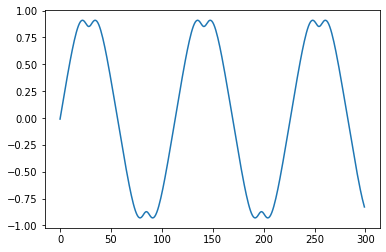

In [ ]:
plt.plot((p1[n,:]-p1.mean())/p1.std())

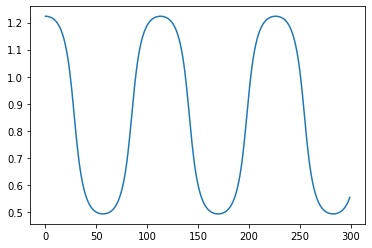

In [ ]:
plt.plot((q2[n,:]-q2.mean()) / (q2.std()+1e-10)) 

#### Increasing Horizon method : like Jonas

In [ ]:
def select_horizon(step,switch_steps = (200,200,150,150,150)  ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 
    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
    else :
        horizon = 300
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
    return horizon

In [ ]:
def select_horizon_wschedule(step,optim,epoch_number, 
                             switch_steps = (200,200,150,150,150)       
                            ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 
    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
        steps = n1
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
        steps = n2
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
        steps = n3
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
        steps = n4
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
        steps = n5
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    else :
        horizon = 300
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
        steps = epoch_number - (n1+n2+n3+n4+n5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
    return horizon, scheduler

In [ ]:
def train(model, train_loader, test_loader, horizon=False, horizon_type=False, switch_steps = (200,200,150,150,150), 
          epochs = 20, 
          w=torch.tensor([0.1,0.1,1.0,1.0], device=device)):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps


    lr = 1e-3
    Ts = 0.005
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            horizon, scheduler = select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
        elif horizon_type == 'auto': 
            horizon = select_horizon(step, switch_steps)

        for x, t_eval in iter(train_loader):
            # x is [batch_size,(q1,p1,q2,p1),time_steps]
            t_eval = t_eval[0,:horizon]

            train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            
            # train_x_hat is [time_steps,batch_size , (q1,p1,q2,p1)] 
            train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss = train_loss + train_loss_mini.item()

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad()
            if horizon == 'schedule':
              scheduler.step()

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:horizon]
   
                    test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))      
                    test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                    test_loss = test_loss + test_loss_mini.item()
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss, test_loss,test_time))
                stats['test_loss'].append(test_loss)
                
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                      .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        stats['train_loss'].append(train_loss)
        
    return stats

In [ ]:
test = False
if test == 'hello':
  print('bla')
elif not test:
  print('ho')

ho


##### Training

In [ ]:
device = 'cpu' # for some reason the training loop is quicker on CPU
# maybe because of how odeint solves the diff eqs ?

In [ ]:
model = load_model()
count_parameters(model)

33303

In [ ]:
train_loader, test_loader, stds = load_data_device(time_steps=800, num_trajectories=125, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.8, batch_size=100)

In [ ]:
train_loader, test_loader, stds = load_data_device(time_steps=300, num_trajectories=1, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=100)

In [ ]:
(1 / (stds+1e-10))*10

tensor([9.1648e+00, 9.7673e+03, 2.3683e+01, 1.0000e+11])

In [ ]:
save_prefix  = 'test_w_0.01_1_0.1_40'# 'ep1000_w_0.3_800_0.8_1000_nosched__tests'test

In [ ]:
a = 0.1
b = 10
weights = [1*a,1*a*b,1,1*b]
print(weights)
# weights = [0.1,1.0,1.0,10.0]

[0.1, 1.0, 1, 10]


In [ ]:
weights_title = ' | weights = '+ str(weights)
weights_title 

' | weights = [0.1, 1.0, 1, 10]'

In [ ]:
epoch_number = 500
stats = train(model, 
              train_loader, 
              test_loader, 
              horizon=False,
              horizon_type='auto',
              switch_steps = (200,200,150,150,100), 
              epochs = epoch_number, 
              w=torch.tensor(weights, device=device)) 

In [ ]:
epoch_number = 600
stats = train(model, 
              train_loader, 
              test_loader, 
              horizon=False,
              horizon_type = 'auto',
              switch_steps = (200,200,200,150,100), 
              epochs = epoch_number, 
              w=torch.tensor(weights, device=device)) 

horizon length : 50
epoch    0 | train time 0.45 | train loss 5.112965e-01 
epoch    1 | train time 0.46 | train loss 4.902800e-01 
epoch    2 | train time 0.41 | train loss 4.630214e-01 
epoch    3 | train time 0.45 | train loss 4.272551e-01 
epoch    4 | train time 0.41 | train loss 3.831464e-01 
epoch    5 | train time 0.43 | train loss 3.340817e-01 
epoch    6 | train time 0.45 | train loss 2.876033e-01 
epoch    7 | train time 0.47 | train loss 2.504523e-01 
epoch    8 | train time 0.45 | train loss 2.246519e-01 
epoch    9 | train time 0.41 | train loss 2.295230e-01 
epoch   10 | train time 0.43 | train loss 2.325797e-01 
epoch   11 | train time 0.41 | train loss 2.103317e-01 
epoch   12 | train time 0.42 | train loss 1.904805e-01 
epoch   13 | train time 0.42 | train loss 1.877424e-01 
epoch   14 | train time 0.42 | train loss 1.836751e-01 
epoch   15 | train time 0.43 | train loss 1.681216e-01 
epoch   16 | train time 0.41 | train loss 1.484351e-01 
epoch   17 | train time 0.43

##### Saving stats and model to disk

In [ ]:
# import json
# PATH = './drive/MyDrive/1_SP_Ham_func/'
# suffix = '27_03'
# stats_path = PATH+'stats/stats'+suffix+'.txt'
# with open(stats_path, 'w') as file:
#      file.write(json.dumps(stats)) # use `json.loads` to do the reverse

In [ ]:
## saving stats to txt file
import json

PATH = './drive/MyDrive/1_SP_Ham_func/'
stats_path = PATH+'stats/'+save_prefix+'stats.txt'

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

In [ ]:
save_stats(PATH, stats, stats_path)

In [ ]:
def read_dict(PATH, stats_path):
    # read the stats txt file
    with open(stats_path) as f:
        data = f.read()

    data = json.loads(data)
    return data

In [ ]:
stats = read_dict(PATH, stats_path)

In [ ]:
# save model to disk
model_name = 'models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [ ]:
# load model from disk
model = load_model()
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

Simple_MLP(
  (H_net): MLP(
    (fc1): Linear(in_features=4, out_features=90, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (1): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (2): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (3): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
    )
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  )
)

##### Plots of training results

IndexError: ignored

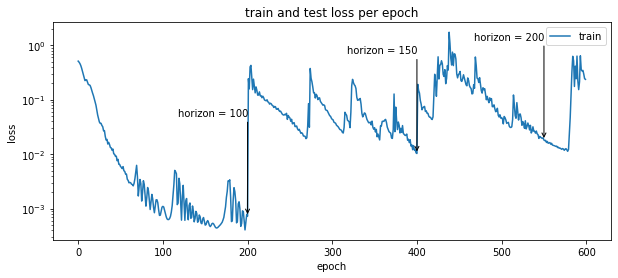

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(epoch_number)
train_test_loss_plot(loss_train, loss_test, epochs, file_path=None)#PATH+'img/'+save_prefix+'train_test_loss.png')

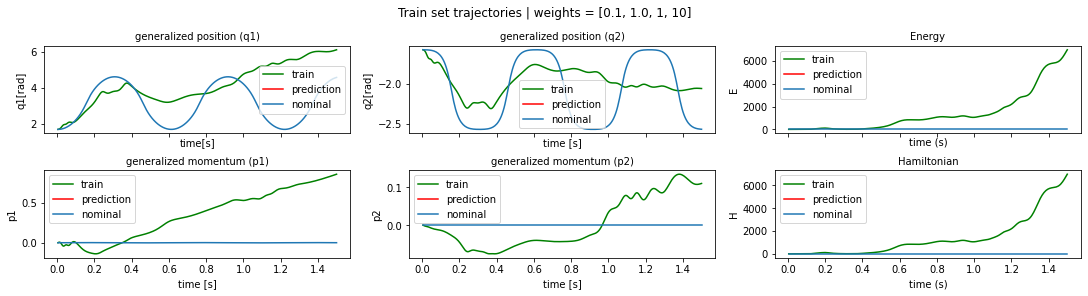

In [ ]:
plot_furuta_hat_nom(train_loader, t_max=300, 
                     title = 'Train set trajectories'+ weights_title, file_path=None)#PATH+'img/'+save_prefix+'train_set_traj.png')

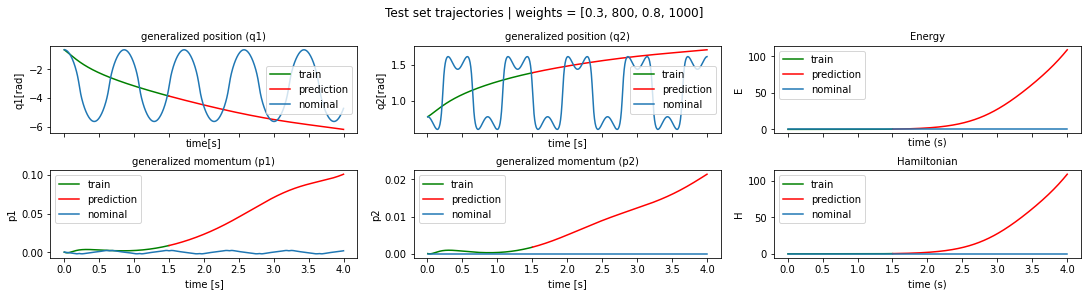

In [ ]:
plot_furuta_hat_nom(test_loader, t_max=300,
                     title = 'Test set trajectories'+ weights_title, file_path=None)#PATH+'img/'+save_prefix+'test_set_traj.png')

In [ ]:
train_loader_2, test_loader_2 , _ = load_data_device(time_steps=2000, num_trajectories=2, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1)

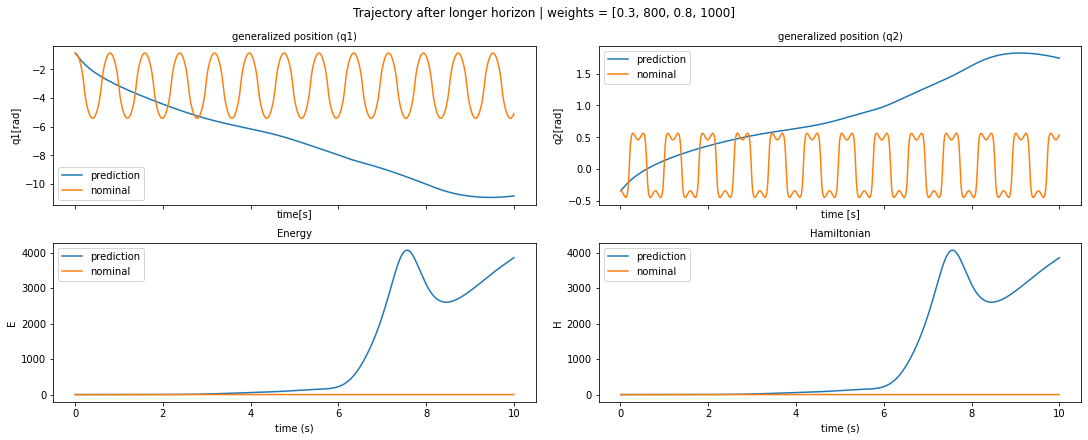

In [ ]:
plot_longer_horizon_furuta(test_loader_2,t1=0,t2=2000, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=None)#PATH+'img/'+save_prefix+'longer_horizon.png')

In [ ]:
train_loader_3, test_loader_3 , _ = load_data_device(time_steps=10000, num_trajectories=2, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1)

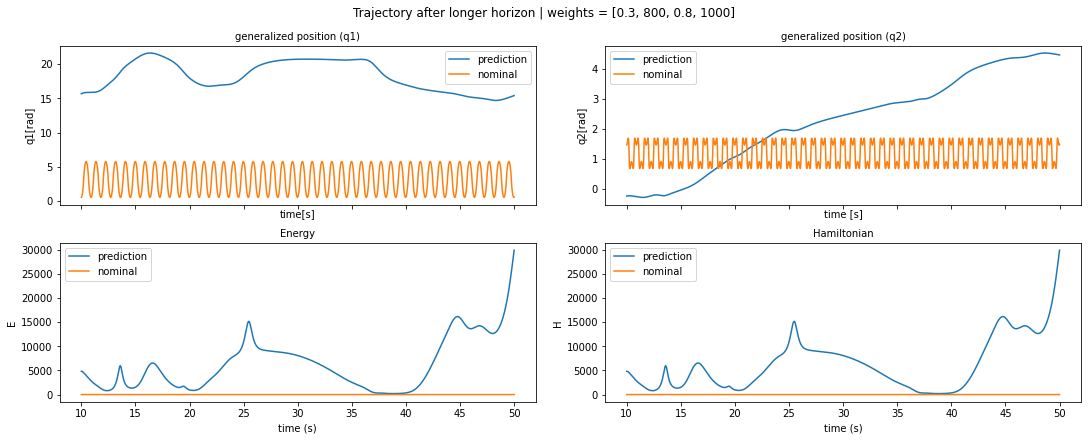

In [ ]:
plot_longer_horizon_furuta(test_loader_3,t1=2000,t2=10000, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=None)#PATH+'img/'+save_prefix+'longer_horizon2.png')

#### Moving horizon method : like Symoden paper

##### prepping data

In [ ]:
def change_data_shape(q1, p1, q2, p2, derivatives):
    
    a = torch.stack((q1, p1, q2, p2),dim=2) # [ nb_trajectoires, nb_time_steps, (q1,p1,q2,p2)]
    print(a.shape)
    b = torch.permute(derivatives,(0,1,2)) # [nb_trajectoires, nb_time_steps, (dp1/dt,dq2/dt,dp2/dt)]
    print(b.shape)
    x = torch.cat((a,b),dim=2)
    print(x.shape)
    # x is now [nb_trajectoires, nb_time_steps, (q1,p1,q2,p2,dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
    return x

In [ ]:
def arrange_data(x, t, num_points=2):
    '''
    Arrange data to feed into neural ODE in small chunks
    Converted to pytorch from the numpy version in the Symoden repository
    ( Also changed some indexes for it to work with data format used in this notebook )
    '''
    assert num_points>=2 and num_points<=len(t) 
    x_stack = []
    for i in range(num_points):
        #print('i',i)
        if i < num_points-1:
            #print(x[:, i:-num_points+i+1,:,:].shape)
            x_stack.append(x[:, i:-num_points+i+1, :])
        else:
            x_stack.append(x[:, i:, :])
    x_stack1 = torch.stack(x_stack, axis=0)

    x_stack = torch.reshape(x_stack1, 
                (num_points, -1,x.shape[2]))
    x_stack = torch.permute(x_stack,[1,0,2])
    t_eval = t[0:num_points] 
    return x_stack, t_eval

In [ ]:
# # Example to illustrate how arrange_data works : 
# x1 = torch.arange(5)
# x2 = torch.arange(10,15)
# x3 = torch.arange(20,25)
# x4 = torch.arange(30,35)

# x5 = torch.stack((x1,x2),dim=1)
# x6 = torch.stack((x3,x4),dim=1)
# x7 = torch.stack((x5,x6,  torch.stack((torch.arange(40,45) ,  torch.arange(50,55)  ),dim=1)     ),dim=0)

# print(x7.shape)

# print(x7)
# num_points=3
# x_stack, t_eval = arrange_data(x7, torch.arange(5), num_points=num_points)
# print(x_stack)

In [ ]:
def load_data_device_horizon(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1,num_points=5):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                    num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                    u=0.0,C_q1=0.0, C_q2=0.0)

    x_new = change_data_shape(q1, p1, q2, p2, derivatives)
    x_arranged, t_eval_arranged = arrange_data(x_new, t_eval, num_points=num_points)
    #x_arranged = torch.permute(x_arranged,(1,0,2))
    q1_new, p1_new, q2_new, p2_new = torch.chunk(x_arranged[:,:,0:4],4,dim=2)
    derivatives_new = x_arranged[:,:,4:8]
    
    q1 = q1_new.squeeze(dim=2).to(device)
    p1 = p1_new.squeeze(dim=2).to(device)
    q2 = q2_new.squeeze(dim=2).to(device)
    p2 = p2_new.squeeze(dim=2).to(device)

    # print(q1.shape)
    energy = energy.to(device)
    derivatives = derivatives_new.to(device)
    t_eval = t_eval_arranged.to(device)
    # print(t_eval.shape)
    print('there are ', q1.shape[0], 'new samples')
    # dataloader to load data in batches
    batch_size_calc = num_trajectories*(time_steps-num_points+1) # new number of samples is num_trajectories*(time_steps-num_points+1 ) (similar to a convolution with stride 1)
    print('calculated batch size', batch_size_calc)
    # batch_size = q1.shape[0] 

    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                        shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader

In [ ]:
## x is [batch_size, (q1,p1,q2,p1), time_steps]

In [ ]:
train_loader, test_loader = load_data_device_horizon(time_steps=200, num_trajectories=5, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=1000, num_points=100)

torch.Size([5, 200, 4])
torch.Size([5, 200, 4])
torch.Size([5, 200, 8])
there are  505 new samples
calculated batch size 505


In [ ]:
50*(200-100+1) # new number of samples is num_trajectories*(time_steps-num_points+1 ) (similar to a convolution with stride 1)

5050

torch.Size([505, 4, 100])
torch.Size([505, 100])


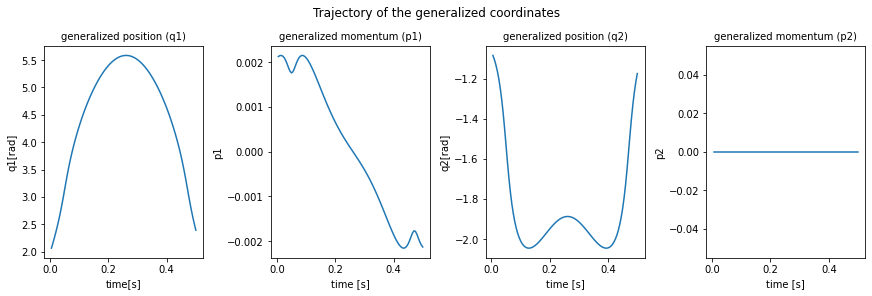

In [ ]:
# just checking that the trajectories were properly split
x,t = next(iter(train_loader))
 
print(x.shape)
print(t.shape)
x = x.detach().cpu()
t= t.detach().cpu()
plot_traj_furuta(t[0,:], x[0,0,:], x[0,1,:], x[0,2,:], x[0,3,:])

##### Train function

In [ ]:
def train_walt_horizon(model, epochs = 20, adjoint = False):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3
    Ts = 0.005
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    w=torch.tensor([0.1,0.1,1.0,1.0], device=device)

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()
        
        
        for x, t_eval in iter(train_loader):
            
            t_eval = t_eval[0,:]

            if adjoint :
                train_x_hat = odeint_adjoint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            
            else :
                train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))

            train_loss_mini = L2_loss(torch.permute(x[:, :, :], (2,0,1)) , train_x_hat[:,:,:],w)#[:,:horizon])
            train_loss = train_loss + train_loss_mini.item() # add detach here

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:]

                    if adjoint :
                        test_x_hat = odeint_adjoint(model, x[:, :, 0], t_eval, method='rk4')      
                    else :
                        test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')   

                    test_loss_mini = L2_loss(torch.permute(x[:, :, :], (2,0,1)), test_x_hat[:,:,:],w)
                    test_loss = test_loss + test_loss_mini.item() # add detach here
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss, test_loss,test_time))
                stats['test_loss'].append(test_loss)
                
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                      .format(step, train_time, train_loss))
        if not test_loader:
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                      .format(step, train_time, train_loss))
        # logging
        stats['train_loss'].append(train_loss)
        
    return stats

##### Training

In [ ]:
device = set_device()

Device Availble: Tesla T4


In [ ]:
torch.cuda.empty_cache() #clear gpu memory

In [ ]:
# device = 'cpu' 

In [ ]:
train_loader, test_loader = load_data_device_horizon(time_steps=300, num_trajectories=100, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=2000,num_points=50)

torch.Size([100, 300, 4])
torch.Size([100, 300, 4])
torch.Size([100, 300, 8])
there are  25100 new samples
calculated batch size 25100


In [ ]:
len(train_loader)

13

In [ ]:
model = load_model()
count_parameters(model)

33303

In [ ]:
epoch_num = 100

In [ ]:
stats = train_walt_horizon(model, epochs = epoch_num, adjoint = False)

epoch    0 | train time 14.06 | train loss 8.455887e-01 
epoch    1 | train time 12.78 | train loss 5.635480e-01 
epoch    2 | train time 12.76 | train loss 4.438245e-01 
epoch    3 | train time 12.71 | train loss 3.596972e-01 
epoch    4 | train time 12.72 | train loss 3.274992e-01 
epoch    5 | train time 12.65 | train loss 2.986338e-01 
epoch    6 | train time 12.52 | train loss 2.814767e-01 
epoch    7 | train time 12.53 | train loss 2.721687e-01 
epoch    8 | train time 12.73 | train loss 2.919741e-01 
epoch    9 | train time 12.65 | train loss 2.681663e-01 
epoch   10 | train time 12.55 | train loss 2.503334e-01 
epoch   11 | train time 12.62 | train loss 2.364503e-01 
epoch   12 | train time 12.68 | train loss 2.375125e-01 
epoch   13 | train time 12.60 | train loss 2.559465e-01 
epoch   14 | train time 12.52 | train loss 2.296176e-01 
epoch   15 | train time 12.81 | train loss 2.248387e-01 
epoch   16 | train time 12.79 | train loss 2.061884e-01 
epoch   17 | train time 12.77 |

Using adjoint method takes about 2x more time for an epoch
Using cpu also uses approx 2-3x more time per epoch

##### Plots of training results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = './drive/MyDrive/1_SP_Ham_func/'

In [ ]:
save_prefix = 'moving_horizon_3_'

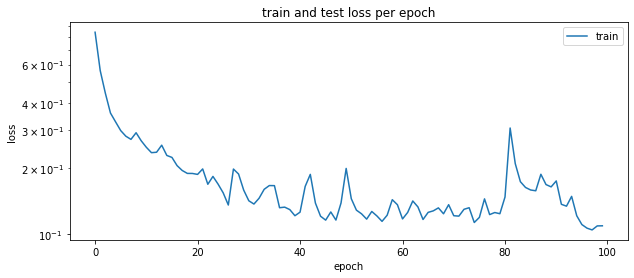

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss'] 
epochs_vec = np.arange(epoch_num)
train_test_loss_plot(loss_train, loss_test, epochs_vec, file_path=None,#PATH+'img/'+save_prefix+'train_test_loss.png',
                            horizons = [],
                            horizon_steps = [],
                            title='train and test loss per epoch')# 

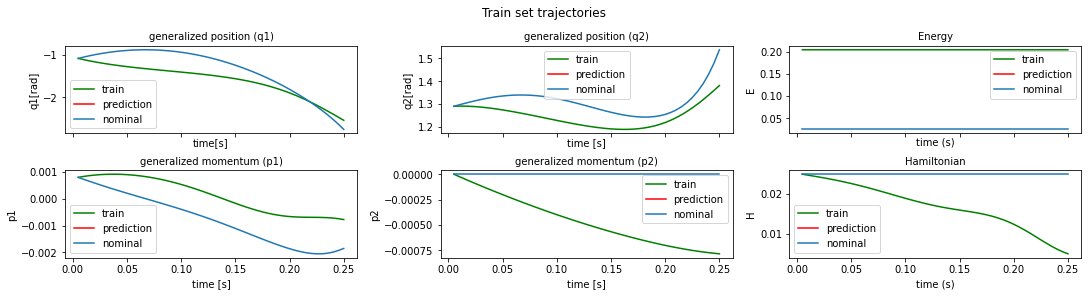

In [ ]:
plot_furuta_hat_nom(train_loader, t_max=300,
                    title = 'Train set trajectories', file_path=None#PATH+'img/'+save_prefix+'train_set_traj.png'
                    ) #

In [ ]:
train_loader_2, test_loader_2 = load_data_device(time_steps=2000, num_trajectories=2, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1)

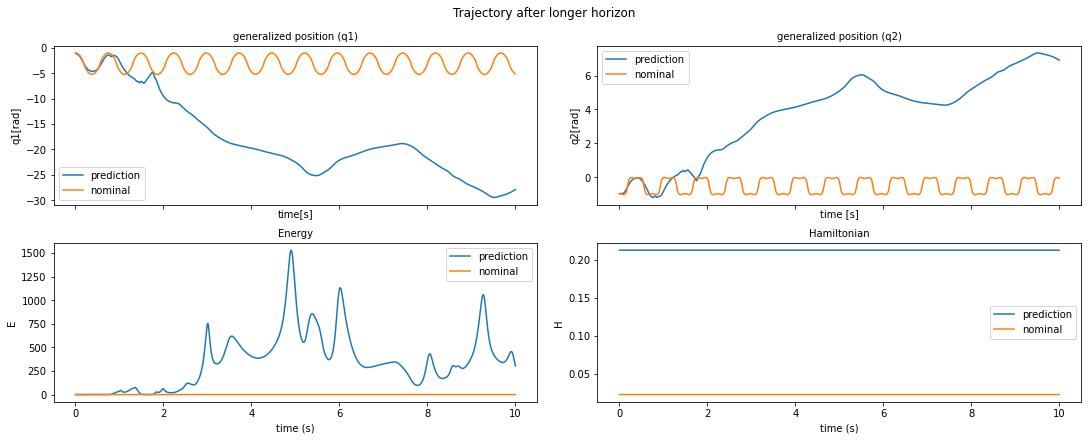

In [ ]:
plot_longer_horizon_furuta(test_loader_2,t1=0,t2=2000, title = 'Trajectory after longer horizon',
                           file_path=PATH+'img/'+save_prefix+'longer_horizon.png') # 

#### Autoencoder Train :

##### train function

In [ ]:
x.shape

torch.Size([2, 300, 4])

In [ ]:
def train_ae(model, 
             autoencoder,
             train_loader, 
             test_loader, 
             horizon=False, 
             horizon_type=False, 
             switch_steps = (200,200,150,150,150),
             steps_ae = 5,
             epochs = 20,
             w=torch.tensor([0.1,0.1,1.0,1.0], device=device)): 
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps
    
    alpha = 1.0
    beta = 1.0
    gamma = 1.0

    lr = 1e-3
    Ts = 0.005
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function

    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()
        if horizon_type == 'schedule':
            horizon, scheduler = select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
        elif horizon_type == 'auto': 
            horizon = select_horizon(step, switch_steps)

        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]
            
            
            if step<=steps_ae:
                if step == 0 : 
                    print('Training the autoencoder')
                    optim = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

                
                # Train the autoencoder alone for the first epochs
                p_hat, q_dot_hat = autoencoder(x[:, :horizon, :])
                # autoencoder only outputs q_dot_hat states
                # print(q_dot_hat.shape)
                train_loss_batch = L2_loss(q_dot_hat, x[:, :horizon, [1,3]])
                print(train_loss_batch.shape,train_loss_batch.item(),x[:, :horizon, [1,3]].shape)
                # print(train_loss_batch)

            if step>steps_ae:
                if step == steps_ae+1 : 
                    print('Training the HNN and autoencoder')
                    # reset optimizer statistics
                    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

                # q_dot_hat is the reconstructed nominal trajectory ; q_dot_hat = decoder(encoder(nominaltrajectory))
                p_hat, q_dot_hat = autoencoder(x[:, :horizon, :])
                
                # x_ae = torch.stack((x[:,:horizon,0], q_dot_hat[:,:,0], x[:, :horizon,1], q_dot_hat[:,:,1]))

                # nominal trajectory in latent space (encoded nominal trajectory)
                z = torch.stack((x[:,:horizon,0], p_hat[:,:,0], x[:, :horizon,1], p_hat[:,:,1]))
                #print(z.shape)

                # model output in latent space
                train_z_hat = odeint(model, z[:, :, 0].T, t_eval, method='rk4', options=dict(step_size=Ts))
                # train_z_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

                # decoded output trajectory
                train_q_dot_hat = autoencoder.decoder(train_z_hat[:horizon,:,:])
                # train_x_hat = [time_steps, batch_size, (q1_HNN, p1_HNN_decoded, q2_HNN, p1_HNN_decoded)] 
                train_x_hat = torch.stack((train_z_hat[:horizon,:,0], train_q_dot_hat[:,:,0], train_z_hat[:horizon,:,2], train_q_dot_hat[:,:,1]))
                train_x_hat = torch.permute(train_x_hat, (2,1,0))

                # loss between HNN output and encoded nominal trajectory (nominal trajectory in latent space)
                loss_HNN_batch = L2_loss(torch.permute(z[:, :, :horizon], (1,2,0)), train_x_hat[:,:horizon,:],w) #[:,:horizon])

                # loss between decoded HNN output and nominal trajectory 
                #x = torch.permute(x[:, :horizon, :], (1,0,2)) 
                loss_prediction_batch = L2_loss(x[:, :horizon, :], train_x_hat[:,:horizon,:],w) 

                # loss between nominal trajectory and decoded(encoded(nominaltrajectory))
                # to make sure the autoencoder properly reconstructs the nominal trajectory
                loss_AE_batch = L2_loss(x[:, :horizon, [1,3]], q_dot_hat[:,:horizon,:],w[2:4])

                # train_loss_batch = L2_loss(torch.permute(z[:, :, :horizon], (2,0,1)) , train_z_hat[:horizon,:,:],w)#[:,:horizon])
                train_loss_batch = alpha*loss_HNN_batch + beta*loss_prediction_batch + gamma*loss_AE_batch
            
            train_loss = train_loss + train_loss_batch.item() 
            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad(set_to_none=True) 

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:horizon]
   
                    test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')      
                    test_loss_batch = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                    test_loss = test_loss + test_loss_batch.item()
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:12e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss, test_loss,test_time))
                stats['test_loss'].append(test_loss)
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                      .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                  .format(step, train_time, train_loss))
        # logging
        stats['train_loss'].append(train_loss)
        
    return stats

##### training

In [289]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=4, 
                 enc_out_dim=2, dec_in_dim = 4, dec_out_dim = 2, activation='tanh') # 'x+sin(x)^2'
count_parameters(autoencoder)

9220

In [ ]:
model = load_model()
count_parameters(model)

33303

In [112]:
train_loader, test_loader, stds = load_data_device(time_steps=300, num_trajectories=1,
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=100)

In [134]:
train_loader_2, test_loader_2, stds = load_data_device(time_steps=300, num_trajectories=100,
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=100)

In [147]:
def train_only_ae(autoencoder, 
                  model,
                  train_loader, 
                  test_loader, 
                  epochs,
                  horizon,
                  lr = 1e-3): 
    alpha = 1.0
    beta = 1.0
    gamma = 1.0

    
    Ts = 0.005
    # params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(autoencoder.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()

        autoencoder.eval()
        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # Train the autoencoder alone for the first epochs

            p_hat, q_dot_hat = autoencoder(x[:, :horizon, :])
            # autoencoder only outputs q_dot_hat states
            # print(q_dot_hat.shape)

            train_loss_batch = L2_loss(q_dot_hat, x[:, :horizon, [1,3]])
            # print(train_loss_batch.shape,train_loss_batch.item(),x[:, :horizon, [1,3]].shape)
            # print(train_loss_batch)

            train_loss = train_loss + train_loss_batch.item() 
            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad() # set_to_none=True
            if not step%50:
                plt.subplots([])
                plt.plot(x[0,:,1],label='nominal')
                plt.plot(q_dot_hat[0,:,0].detach(),label='autenc')
                plt.legend()
                plt.show()

                # plt.plot(x[1,:,1],label='nominal')
                # plt.plot(q_dot_hat[1,:,0].detach(),label='autenc')
                # plt.legend()
                # plt.show()

        t2 = time.time()
        train_time = t2-t1
        if not step%20:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                    .format(step, train_time, train_loss))

        # logging
        stats['train_loss'].append(train_loss)

    return stats

In [72]:
model = load_model()

In [299]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=200, enc_in_dim=4, 
                 enc_out_dim=2, dec_in_dim = 4, dec_out_dim = 2, activation='tanh') # 'x+sin(x)^2'


count_parameters(autoencoder)

83204

In [274]:
x, y = next(iter(train_loader)) 

In [ ]:
print(x.shape) 
a,b = autoencoder(torch.permute(x[:,:,:], (0,2,1)))
print(b.shape)
n=50
plt.plot(x[n,1,:])
plt.plot(b[n,:,0].detach())

In [276]:
len(train_loader_2)

1

In [ ]:
stats_2 = train_only_ae(autoencoder,
                        model,
                        train_loader_2, 
                        test_loader_2,
                        epochs=2000, 
                        horizon=100,
                        lr = 1e-3)

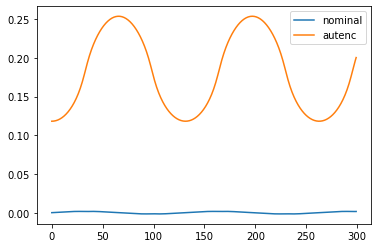

epoch    0 | train time 0.21 | train loss 3.808003e-02 
epoch   20 | train time 0.01 | train loss 8.367418e-03 
epoch   40 | train time 0.01 | train loss 2.041252e-03 


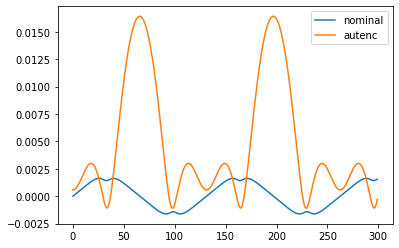

epoch   60 | train time 0.01 | train loss 3.400161e-04 
epoch   80 | train time 0.01 | train loss 2.538894e-05 


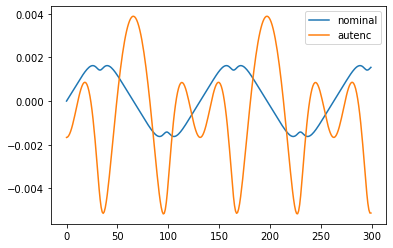

epoch  100 | train time 0.18 | train loss 1.337200e-05 
epoch  120 | train time 0.01 | train loss 6.059107e-06 
epoch  140 | train time 0.01 | train loss 4.174633e-06 


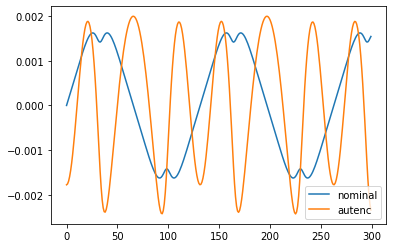

epoch  160 | train time 0.01 | train loss 3.289328e-06 
epoch  180 | train time 0.00 | train loss 2.839265e-06 


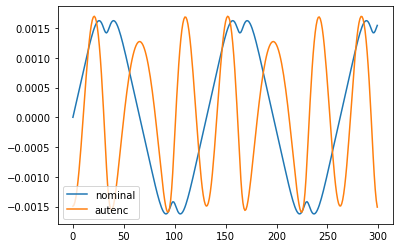

epoch  200 | train time 0.18 | train loss 2.530966e-06 
epoch  220 | train time 0.01 | train loss 2.299932e-06 
epoch  240 | train time 0.01 | train loss 2.124573e-06 


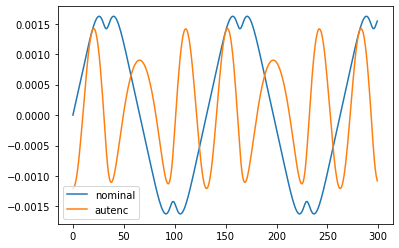

epoch  260 | train time 0.01 | train loss 1.991092e-06 
epoch  280 | train time 0.00 | train loss 1.889728e-06 


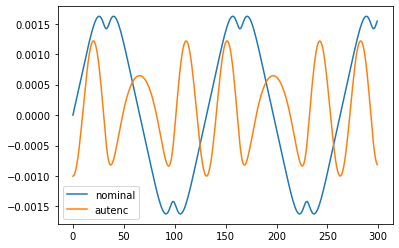

epoch  300 | train time 0.17 | train loss 1.812776e-06 
epoch  320 | train time 0.01 | train loss 1.754221e-06 
epoch  340 | train time 0.01 | train loss 1.709315e-06 


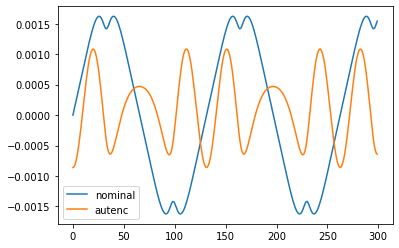

epoch  360 | train time 0.00 | train loss 1.677466e-06 
epoch  380 | train time 0.01 | train loss 2.837870e-03 


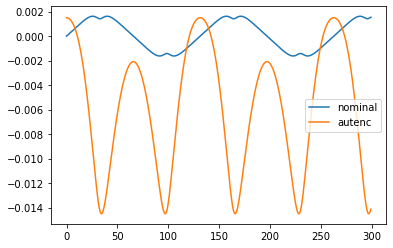

epoch  400 | train time 0.20 | train loss 2.100614e-04 
epoch  420 | train time 0.01 | train loss 3.484876e-05 
epoch  440 | train time 0.01 | train loss 1.396315e-05 


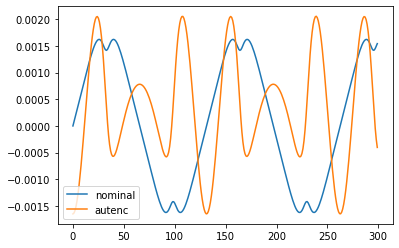

epoch  460 | train time 0.00 | train loss 3.585753e-06 
epoch  480 | train time 0.00 | train loss 2.058270e-06 


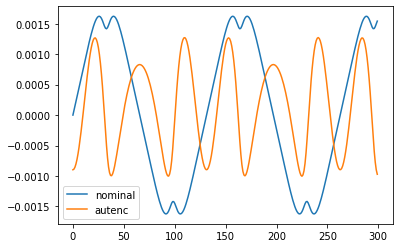

epoch  500 | train time 0.18 | train loss 1.861801e-06 
epoch  520 | train time 0.01 | train loss 1.786438e-06 
epoch  540 | train time 0.01 | train loss 1.725391e-06 


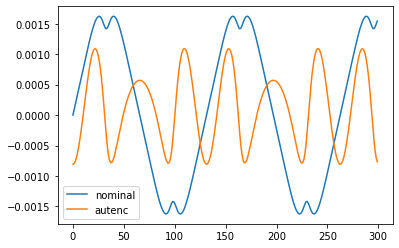

epoch  560 | train time 0.01 | train loss 1.677764e-06 
epoch  580 | train time 0.01 | train loss 1.638831e-06 


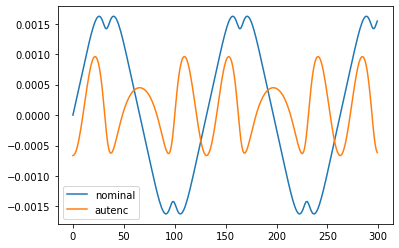

epoch  600 | train time 0.18 | train loss 1.606563e-06 
epoch  620 | train time 0.01 | train loss 1.579730e-06 
epoch  640 | train time 0.01 | train loss 1.557271e-06 


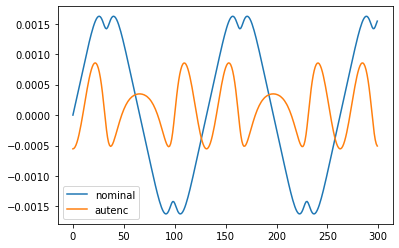

epoch  660 | train time 0.01 | train loss 1.538340e-06 
epoch  680 | train time 0.01 | train loss 1.522259e-06 


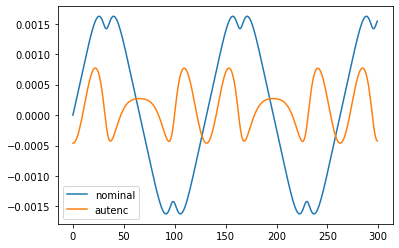

epoch  700 | train time 0.20 | train loss 1.508511e-06 
epoch  720 | train time 0.01 | train loss 1.496649e-06 
epoch  740 | train time 0.01 | train loss 1.486322e-06 


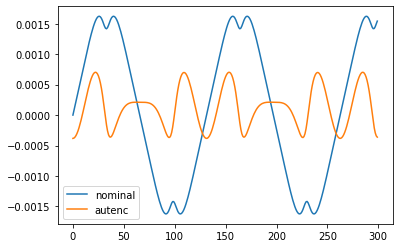

epoch  760 | train time 0.01 | train loss 1.477255e-06 
epoch  780 | train time 0.01 | train loss 1.469245e-06 


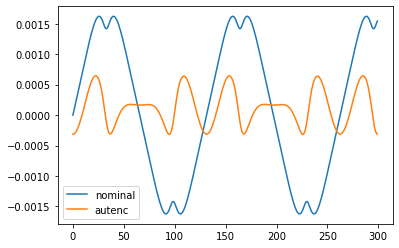

epoch  800 | train time 0.18 | train loss 1.462079e-06 
epoch  820 | train time 0.01 | train loss 1.455616e-06 
epoch  840 | train time 0.01 | train loss 1.449738e-06 


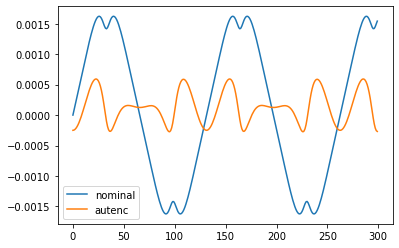

epoch  860 | train time 0.01 | train loss 1.444386e-06 
epoch  880 | train time 0.00 | train loss 1.439461e-06 


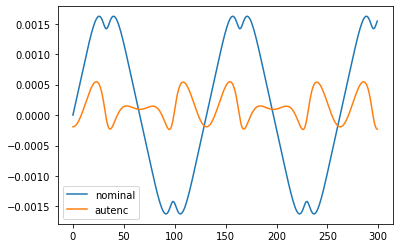

epoch  900 | train time 0.16 | train loss 1.434909e-06 
epoch  920 | train time 0.01 | train loss 1.430697e-06 
epoch  940 | train time 0.00 | train loss 1.426775e-06 


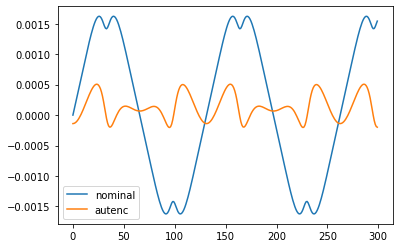

epoch  960 | train time 0.01 | train loss 1.423126e-06 
epoch  980 | train time 0.00 | train loss 1.419706e-06 


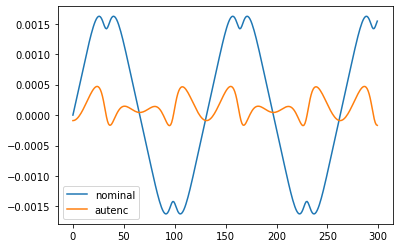

epoch 1000 | train time 0.18 | train loss 1.416528e-06 
epoch 1020 | train time 0.01 | train loss 1.413592e-06 
epoch 1040 | train time 0.01 | train loss 2.455837e-06 


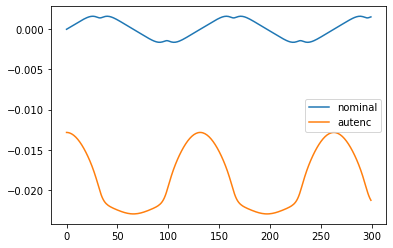

epoch 1060 | train time 0.00 | train loss 4.306773e-03 
epoch 1080 | train time 0.00 | train loss 9.542079e-05 


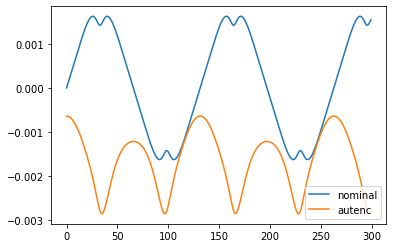

epoch 1100 | train time 0.18 | train loss 2.888291e-05 
epoch 1120 | train time 0.01 | train loss 6.490885e-06 
epoch 1140 | train time 0.01 | train loss 1.811108e-06 


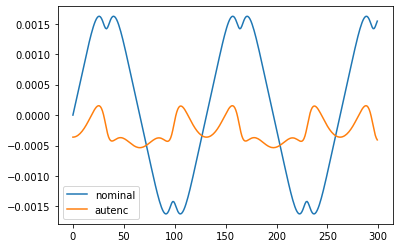

epoch 1160 | train time 0.01 | train loss 1.427974e-06 
epoch 1180 | train time 0.00 | train loss 1.384032e-06 


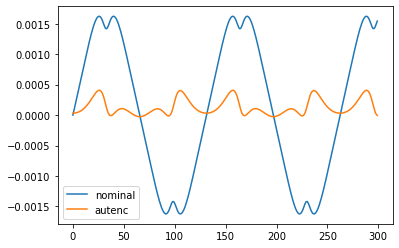

epoch 1200 | train time 0.18 | train loss 1.382133e-06 
epoch 1220 | train time 0.01 | train loss 1.382748e-06 
epoch 1240 | train time 0.01 | train loss 1.383605e-06 


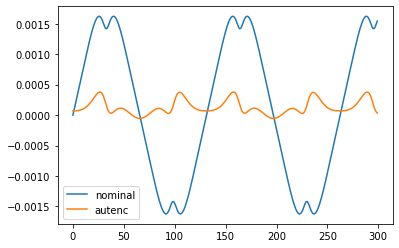

epoch 1260 | train time 0.01 | train loss 1.384693e-06 
epoch 1280 | train time 0.01 | train loss 1.385761e-06 


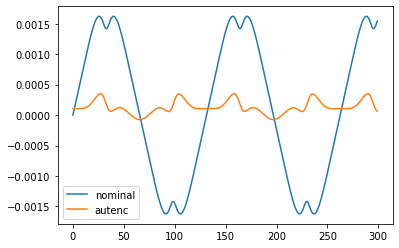

epoch 1300 | train time 0.19 | train loss 1.386809e-06 
epoch 1320 | train time 0.01 | train loss 1.387797e-06 
epoch 1340 | train time 0.00 | train loss 1.388754e-06 


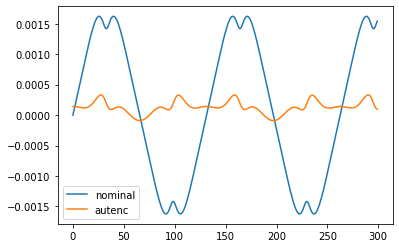

epoch 1360 | train time 0.00 | train loss 1.389609e-06 
epoch 1380 | train time 0.01 | train loss 1.390420e-06 


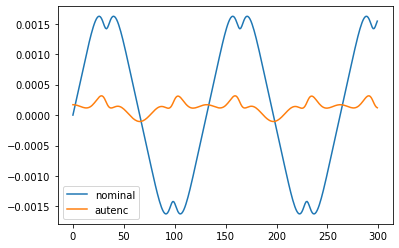

epoch 1400 | train time 0.17 | train loss 1.391139e-06 
epoch 1420 | train time 0.01 | train loss 1.391821e-06 
epoch 1440 | train time 0.01 | train loss 1.392421e-06 


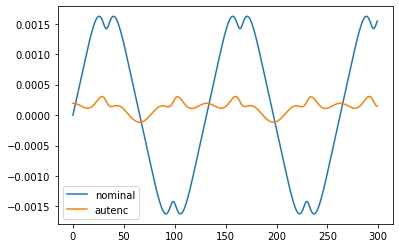

epoch 1460 | train time 0.01 | train loss 1.392940e-06 
epoch 1480 | train time 0.01 | train loss 1.393399e-06 


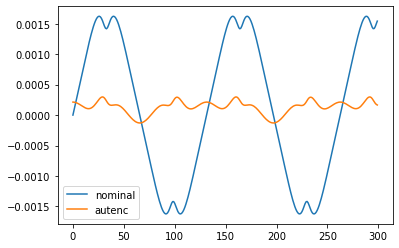

epoch 1500 | train time 0.17 | train loss 1.393784e-06 
epoch 1520 | train time 0.01 | train loss 1.394118e-06 
epoch 1540 | train time 0.00 | train loss 1.394400e-06 


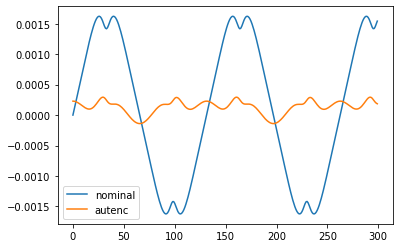

epoch 1560 | train time 0.00 | train loss 1.394619e-06 
epoch 1580 | train time 0.00 | train loss 1.394805e-06 


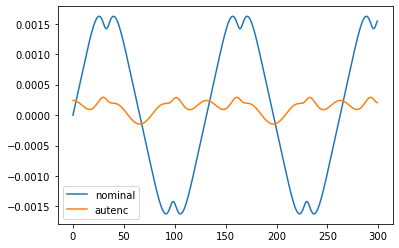

epoch 1600 | train time 0.18 | train loss 1.394922e-06 
epoch 1620 | train time 0.01 | train loss 1.395023e-06 
epoch 1640 | train time 0.01 | train loss 1.395164e-06 


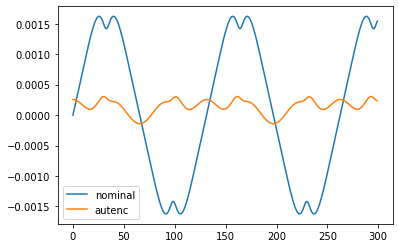

epoch 1660 | train time 0.01 | train loss 6.062515e-06 
epoch 1680 | train time 0.00 | train loss 1.912057e-04 


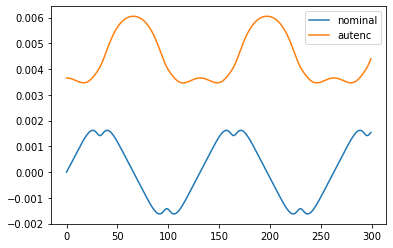

epoch 1700 | train time 0.18 | train loss 1.454099e-04 
epoch 1720 | train time 0.01 | train loss 2.214240e-05 
epoch 1740 | train time 0.01 | train loss 4.150240e-06 


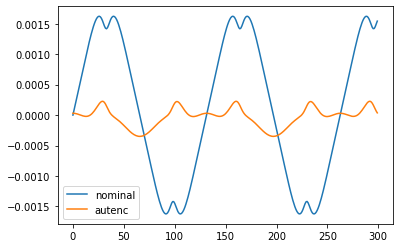

epoch 1760 | train time 0.00 | train loss 1.756387e-06 
epoch 1780 | train time 0.01 | train loss 1.475067e-06 


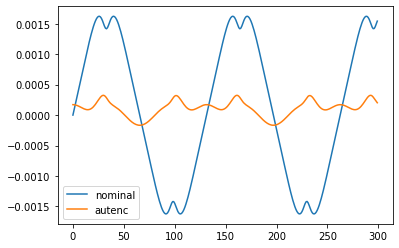

epoch 1800 | train time 0.20 | train loss 1.444807e-06 
epoch 1820 | train time 0.01 | train loss 1.442934e-06 
epoch 1840 | train time 0.01 | train loss 1.440599e-06 


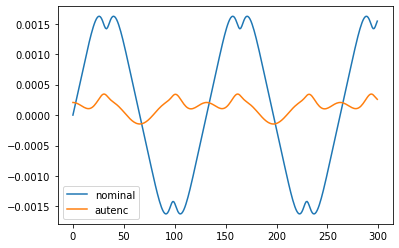

epoch 1860 | train time 0.01 | train loss 1.439261e-06 
epoch 1880 | train time 0.01 | train loss 2.626748e-06 


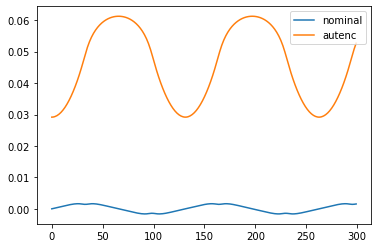

epoch 1900 | train time 0.19 | train loss 2.701486e-03 
epoch 1920 | train time 0.01 | train loss 2.683325e-05 
epoch 1940 | train time 0.01 | train loss 2.303104e-05 


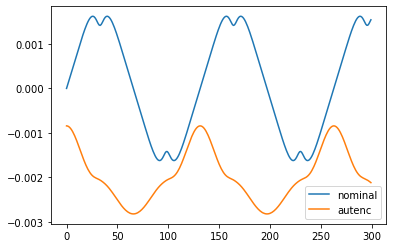

epoch 1960 | train time 0.01 | train loss 2.323432e-06 
epoch 1980 | train time 0.00 | train loss 1.597853e-06 


In [300]:
stats_2 = train_only_ae(autoencoder, 
                        model, 
                        train_loader, 
                        test_loader, 
                        epochs=2000, 
                        horizon=300, 
                        lr = 1e-3) 

In [312]:
x.shape

torch.Size([100, 4, 300])

In [180]:
a,b = autoencoder(x)

In [181]:
a.shape

torch.Size([2, 300, 2])

In [182]:
b.shape

torch.Size([2, 300, 2])

In [183]:
a

tensor([[[-0.1036, -0.0723],
         [-0.1036, -0.0723],
         [-0.1036, -0.0720],
         ...,
         [-0.0947, -0.0128],
         [-0.0926, -0.0070],
         [-0.0902, -0.0006]],

        [[-0.0398, -0.0800],
         [-0.0398, -0.0799],
         [-0.0399, -0.0794],
         ...,
         [-0.0406, -0.0768],
         [-0.0403, -0.0780],
         [-0.0401, -0.0790]]], grad_fn=<AddBackward0>)

In [184]:
b

tensor([[[ 0.0939,  0.0027],
         [ 0.0939,  0.0028],
         [ 0.0940,  0.0029],
         ...,
         [ 0.1278,  0.0329],
         [ 0.1304,  0.0346],
         [ 0.1332,  0.0363]],

        [[ 0.0834, -0.0203],
         [ 0.0834, -0.0203],
         [ 0.0835, -0.0201],
         ...,
         [ 0.0843, -0.0191],
         [ 0.0840, -0.0196],
         [ 0.0837, -0.0200]]], grad_fn=<AddBackward0>)

In [185]:
x

tensor([[[ 1.3461e+00,  0.0000e+00,  1.4048e+00,  0.0000e+00],
         [ 1.3475e+00,  7.4035e-05,  1.4050e+00,  0.0000e+00],
         [ 1.3518e+00,  1.4815e-04,  1.4053e+00,  0.0000e+00],
         ...,
         [ 2.4183e+00,  1.6984e-03,  1.2664e+00,  0.0000e+00],
         [ 2.5081e+00,  1.6842e-03,  1.2323e+00,  0.0000e+00],
         [ 2.6040e+00,  1.6552e-03,  1.1921e+00,  0.0000e+00]],

        [[ 1.0055e+00,  0.0000e+00, -8.0113e-01,  0.0000e+00],
         [ 1.0069e+00,  6.4150e-05, -8.0081e-01,  0.0000e+00],
         [ 1.0110e+00,  1.2850e-04, -7.9986e-01,  0.0000e+00],
         ...,
         [ 1.0347e+00, -2.9924e-04, -7.9449e-01,  0.0000e+00],
         [ 1.0234e+00, -2.3349e-04, -7.9701e-01,  0.0000e+00],
         [ 1.0149e+00, -1.6842e-04, -7.9896e-01,  0.0000e+00]]])

In [33]:
horizon = 100

In [72]:
x, t_eval =  next(iter(train_loader))

In [73]:
t_eval = t_eval[0,:horizon]

In [74]:
t_eval.shape

torch.Size([100])

In [75]:
x.shape

torch.Size([2, 4, 300])

In [76]:
x[:, :, :horizon].shape

torch.Size([2, 4, 100])

In [77]:
x = torch.permute(x,(0,2,1))

In [78]:
x.shape

torch.Size([2, 300, 4])

In [79]:
p_hat, q_dot_hat = autoencoder(x[:, :horizon, :])

In [80]:
Ts = 0.005

In [81]:
step = 5

In [82]:
steps_ae = 10

In [84]:
step = 15

In [85]:
q_dot_hat.shape

torch.Size([2, 100, 2])

In [86]:
x.shape

torch.Size([2, 300, 4])

In [87]:
w=torch.tensor([0.1,0.1,1.0,1.0])

In [105]:
w[2:4]

tensor([1., 1.])

In [55]:
z.shape

torch.Size([4, 2, 100])

In [56]:
t_eval.shape

torch.Size([100])

In [57]:
train_z_hat.shape

torch.Size([100, 2, 4])

In [59]:
torch.permute(z[:, :, :horizon], (2,1,0)).shape

torch.Size([100, 2, 4])

In [62]:
x.shape

torch.Size([2, 300, 4])

In [66]:
torch.permute(x[:, :, :horizon], (1,0,2)).shape

torch.Size([300, 2, 4])